We will cover the following recipes in this chapter:

- Generating a synthetic dataset for text classification problems
- Preparing the test dataset for batch transform inference jobs
- Training and deploying a BlazingText model
- Using Batch Transform for inference
- Generating a synthetic time-series dataset
- Performing the train-test split on a time series dataset
- Training and deploying a DeepAR model
- Performing probabilistic forecasting with a deployed DeepAR model

## Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify

# install nlp libs
!pip install transformers

In [37]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer

In [24]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker-exp123"
training_instance_type = "ml.m5.xlarge"

In [3]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)

## Generating a synthetic dataset for text classification problems

In [4]:
%%capture
!pip install faker

In [5]:
from faker import Faker
faker = Faker()

In [7]:
positive_custom_list = [
    'this is good', 
    'i like it', 
    'very delicious', 
    'i would recommend this to my friends',
    'food in the restaurant',
    'spaghetti chicken soup',
    'dinner time',
    'tastes good',
    'donut',
    'very good',
    'impressive']

def generate_positive_sentences():
    return faker.sentence(
        ext_word_list=positive_custom_list
    )

positive_sentences = []

for i in range(0, 1000):
    item = generate_positive_sentences()
    item = item.replace(".","")
    positive_sentences.append(item)

positive_sentences[:10]

['Food In The Restaurant tastes good impressive food in the restaurant spaghetti chicken soup',
 'I Would Recommend This To My Friends very good very good donut',
 'Impressive donut impressive spaghetti chicken soup i like it',
 'Very Good food in the restaurant this is good',
 'Very Good impressive very delicious impressive very good food in the restaurant very delicious spaghetti chicken soup',
 'I Like It very good food in the restaurant dinner time dinner time',
 'Very Delicious spaghetti chicken soup this is good i like it i like it this is good',
 'I Like It very delicious i would recommend this to my friends donut donut dinner time spaghetti chicken soup',
 'Very Good very delicious i like it donut',
 'This Is Good food in the restaurant dinner time spaghetti chicken soup']

In [8]:
negative_custom_list = [
    'this is bad', 
    'i hate it', 
    'there are better restaurants out there', 
    'i will not recommend this to my friends',
    'food in the restaurant',
    'spaghetti chicken soup',
    'dinner time',
    'tastes bad',
    'donut',
    'very bad',
    'not impressive']

def generate_negative_sentences():
    return faker.sentence(
        ext_word_list=negative_custom_list
    )

negative_sentences = []

for i in range(0, 1000):
    item = generate_negative_sentences()
    item = item.replace(".","")
    negative_sentences.append(item)

negative_sentences[:10]

['I Hate It there are better restaurants out there spaghetti chicken soup there are better restaurants out there',
 'Not Impressive i will not recommend this to my friends there are better restaurants out there not impressive this is bad',
 'Not Impressive i will not recommend this to my friends tastes bad there are better restaurants out there there are better restaurants out there there are better restaurants out there very bad',
 'Spaghetti Chicken Soup dinner time this is bad tastes bad not impressive donut food in the restaurant',
 'Very Bad donut not impressive donut i hate it this is bad',
 'Dinner Time there are better restaurants out there not impressive there are better restaurants out there not impressive food in the restaurant',
 'Dinner Time food in the restaurant i hate it there are better restaurants out there spaghetti chicken soup very bad i hate it',
 'Dinner Time very bad spaghetti chicken soup',
 'Food In The Restaurant i will not recommend this to my friends i will

In [9]:
positive_df = pd.DataFrame(
    positive_sentences, 
    columns=['text']
)

positive_df.insert(
    0, 
    "label", 
    "__label__positive"
)

negative_df = pd.DataFrame(
    negative_sentences, 
    columns=['text']
)

negative_df.insert(
    0, 
    "label", 
    "__label__negative"
)

all_df = pd.concat(
    [positive_df, negative_df], 
    ignore_index=True
)

all_df

,label,text
0,__label__positive,Food In The Restaurant tastes good impressive ...
1,__label__positive,I Would Recommend This To My Friends very good...
2,__label__positive,Impressive donut impressive spaghetti chicken ...
3,__label__positive,Very Good food in the restaurant this is good
4,__label__positive,Very Good impressive very delicious impressive...
...,...,...
1995,__label__negative,There Are Better Restaurants Out There donut d...
1996,__label__negative,I Will Not Recommend This To My Friends spaghe...
1997,__label__negative,This Is Bad donut there are better restaurants...
1998,__label__negative,I Hate It spaghetti chicken soup food in the r...


In [10]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(
    all_df, 
    test_size=0.2
) 

train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.25
)

!mkdir tmp 

train_df.to_csv(
    "synthetic.train.txt", 
    header=False, 
    index=False, 
    sep=" ", 
    quotechar=" "
)

val_df.to_csv(
    "synthetic.validation.txt", 
    header=False, 
    index=False, 
    sep=" ", 
    quotechar=" "
) 

test_df.to_csv(
    "synthetic.test.txt", 
    header=False, 
    index=False, 
    sep=" ", 
    quotechar=" "
)

!head synthetic.train.txt

__label__negative  I  Hate  It  dinner  time  this  is  bad  donut  very  bad  donut 
__label__positive  Dinner  Time  i  would  recommend  this  to  my  friends  dinner  time  this  is  good 
__label__negative  Very  Bad  tastes  bad  this  is  bad  i  hate  it  donut  donut  food  in  the  restaurant 
__label__negative  I  Hate  It  not  impressive  not  impressive 
__label__negative  I  Hate  It  i  will  not  recommend  this  to  my  friends  spaghetti  chicken  soup  dinner  time  donut 
__label__negative  Food  In  The  Restaurant  donut  not  impressive  tastes  bad  there  are  better  restaurants  out  there  i  hate  it 
__label__negative  I  Will  Not  Recommend  This  To  My  Friends  tastes  bad  very  bad  food  in  the  restaurant  i  hate  it 
__label__positive  Dinner  Time  this  is  good  food  in  the  restaurant  very  delicious 
__label__positive  Food  In  The  Restaurant  donut  spaghetti  chicken  soup  dinner  time  i  would  recommend  this  to  my  friends  

In [26]:
!aws s3 cp synthetic.train.txt s3://{bucket}/{prefix}/input/synthetic.train.txt 
!aws s3 cp synthetic.validation.txt s3://{bucket}/{prefix}/input/synthetic.validation.txt

upload: ./synthetic.train.txt to s3://sagemaker-us-east-1-390354360073/sagemaker-exp123/input/synthetic.train.txt
upload: ./synthetic.validation.txt to s3://sagemaker-us-east-1-390354360073/sagemaker-exp123/input/synthetic.validation.txt


## Preparing the Test Dataset for Batch Transform Inference Jobs

In [27]:
test_df_without_label = test_df.drop(
    columns="label"
)

def to_jsonlines(text):
    return '{"source": "' + text +'"}'

tmp = test_df_without_label['text'].apply(
    to_jsonlines
)

test_df_without_label['text'] = tmp

test_df_without_label.to_csv(
    "synthetic.test_without_labels.txt", 
    header=False, 
    index=False, 
    sep=" ", 
    quotechar=" "
)

!head synthetic.test_without_labels.txt

 {"source":  "There  Are  Better  Restaurants  Out  There  there  are  better  restaurants  out  there  dinner  time  tastes  bad  not  impressive  i  hate  it"} 
 {"source":  "Tastes  Good  this  is  good  food  in  the  restaurant  i  would  recommend  this  to  my  friends"} 
 {"source":  "Tastes  Good  i  would  recommend  this  to  my  friends  very  good  this  is  good  i  would  recommend  this  to  my  friends"} 
 {"source":  "There  Are  Better  Restaurants  Out  There  food  in  the  restaurant  not  impressive"} 
 {"source":  "Dinner  Time  dinner  time  this  is  bad  food  in  the  restaurant  there  are  better  restaurants  out  there"} 
 {"source":  "Donut  there  are  better  restaurants  out  there  donut  there  are  better  restaurants  out  there  donut  spaghetti  chicken  soup  food  in  the  restaurant"} 
 {"source":  "Donut  impressive  food  in  the  restaurant  this  is  good  very  delicious  impressive  impressive"} 
 {"source":  "Dinner  Time  not  impres

In [28]:
!aws s3 cp synthetic.test_without_labels.txt s3://{bucket}/{prefix}/input/synthetic.test_without_labels.txt

upload: ./synthetic.test_without_labels.txt to s3://sagemaker-us-east-1-390354360073/sagemaker-exp123/input/synthetic.test_without_labels.txt


## Training and Deploying a BlazingText model

In [29]:
s3_train_data = 's3://{}/{}/input/{}'.format(
    bucket, 
    prefix, 
    "synthetic.train.txt"
)
s3_validation_data = 's3://{}/{}/input/{}'.format(
    bucket, 
    prefix, 
    "synthetic.validation.txt"
)
s3_output_location = 's3://{}/{}/output'.format(
    bucket, 
    prefix
)

In [31]:
container = sagemaker.image_uris.retrieve("blazingtext", region, "1")
container

'811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1'

In [32]:
estimator = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type=training_instance_type,
    input_mode= 'File',
    output_path=s3_output_location,
    sagemaker_session=sess
)

In [33]:
estimator.set_hyperparameters(
    mode="supervised", 
    min_count=2
)

In [35]:
train_data = TrainingInput(
    s3_train_data, 
    distribution='FullyReplicated',   
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

validation_data = TrainingInput(
    s3_validation_data, 
    distribution='FullyReplicated', 
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

data_channels = {
    'train': train_data, 
    'validation': validation_data
}

In [36]:
%%time
estimator.fit(
    inputs=data_channels, 
    logs=True
)

2022-06-10 21:18:56 Starting - Starting the training job...
2022-06-10 21:19:20 Starting - Preparing the instances for trainingProfilerReport-1654895936: InProgress
......
2022-06-10 21:20:21 Downloading - Downloading input data...
2022-06-10 21:20:55 Training - Training image download completed. Training in progress..Arguments: train
[06/10/2022 21:20:58 WARNING 140535536392000] Loggers have already been setup.
[06/10/2022 21:20:58 WARNING 140535536392000] Loggers have already been setup.
[06/10/2022 21:20:58 INFO 140535536392000] nvidia-smi took: 0.05034446716308594 secs to identify 0 gpus
[06/10/2022 21:20:58 INFO 140535536392000] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[06/10/2022 21:20:58 INFO 140535536392000] Processing /opt/ml/input/data/train/synthetic.train.txt . File size: 0.14861774444580078 MB
[06/10/2022 21:20:58 INFO 140535536392000] Processing /opt/ml/input/data/validation/synthetic.validation.t

In [38]:
training_job_name = estimator.latest_training_job.name
training_job_name

'blazingtext-2022-06-10-21-18-56-104'

In [39]:
endpoint = estimator.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.r5.large'
)

-----!

In [40]:
sentences = [
    "that is bad", 
    "the apple tastes good", 
    "i would recommend it to my friends"
]

payload = {"instances" : sentences}

endpoint.serializer = JSONSerializer()
response = endpoint.predict(payload)
predictions = json.loads(response)

print(json.dumps(predictions, indent=2))

[
  {
    "label": [
      "__label__negative"
    ],
    "prob": [
      0.8220781683921814
    ]
  },
  {
    "label": [
      "__label__positive"
    ],
    "prob": [
      0.8135973811149597
    ]
  },
  {
    "label": [
      "__label__positive"
    ],
    "prob": [
      0.6572932600975037
    ]
  }
]


## Using Batch Transform for Inference

In [41]:
path = 's3://{}/{}/input/{}'.format(
    bucket, 
    prefix, 
    "synthetic.test_without_labels.txt"
)

s3_test_without_labels_data = path

path = 's3://{}/{}/batch-prediction'.format(
    bucket, 
    prefix
)

batch_output = path

In [42]:
estimator = Estimator.attach(training_job_name)

transformer = estimator.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge', 
    output_path=batch_output
)

transformer.transform(
    data=s3_test_without_labels_data, 
    data_type='S3Prefix',
    content_type='application/jsonlines', 
    split_type='Line'
)

transformer.wait()


2022-06-10 21:23:41 Starting - Preparing the instances for training
2022-06-10 21:23:41 Downloading - Downloading input data
2022-06-10 21:23:41 Training - Training image download completed. Training in progress.
2022-06-10 21:23:41 Uploading - Uploading generated training model
2022-06-10 21:23:41 Completed - Training job completed
..................................Arguments: serve
[06/10/2022 21:34:21 INFO 140648603891520] Finding and loading model
[06/10/2022 21:34:21 INFO 140648603891520] Trying to load model from /opt/ml/model/model.bin
[06/10/2022 21:34:22 INFO 140648603891520] Number of server workers: 4
[2022-06-10 21:34:22 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2022-06-10 21:34:22 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-06-10 21:34:22 +0000] [1] [INFO] Using worker: sync
[2022-06-10 21:34:22 +0000] [34] [INFO] Booting worker with pid: 34
[2022-06-10 21:34:22 +0000] [35] [INFO] Booting worker with pid: 35
[2022-06-10 21:34:22 +0000] [36] [INFO] Booti

![](https://github.com/sparsh-ai/notebooks/raw/main/img/rec1-blazingtext2.gif)

In [64]:
!aws s3 cp {batch_output} ./ --recursive

download: s3://sagemaker-us-east-1-390354360073/sagemaker-exp123/batch-prediction/synthetic.test_without_labels.txt.out to ./synthetic.test_without_labels.txt.out


In [65]:
!head synthetic.test_without_labels.txt.out

{"label": ["__label__negative"], "prob": [0.7296757102012634]}
{"label": ["__label__positive"], "prob": [0.6667083501815796]}
{"label": ["__label__positive"], "prob": [0.7501630187034607]}
{"label": ["__label__negative"], "prob": [0.5995490550994873]}
{"label": ["__label__negative"], "prob": [0.6950123906135559]}
{"label": ["__label__negative"], "prob": [0.7102949619293213]}
{"label": ["__label__positive"], "prob": [0.691921591758728]}
{"label": ["__label__negative"], "prob": [0.6861161589622498]}
{"label": ["__label__positive"], "prob": [0.6114131212234497]}
{"label": ["__label__positive"], "prob": [0.6541267037391663]}


In [66]:
!head synthetic.test_without_labels.txt

 {"source":  "There  Are  Better  Restaurants  Out  There  there  are  better  restaurants  out  there  dinner  time  tastes  bad  not  impressive  i  hate  it"} 
 {"source":  "Tastes  Good  this  is  good  food  in  the  restaurant  i  would  recommend  this  to  my  friends"} 
 {"source":  "Tastes  Good  i  would  recommend  this  to  my  friends  very  good  this  is  good  i  would  recommend  this  to  my  friends"} 
 {"source":  "There  Are  Better  Restaurants  Out  There  food  in  the  restaurant  not  impressive"} 
 {"source":  "Dinner  Time  dinner  time  this  is  bad  food  in  the  restaurant  there  are  better  restaurants  out  there"} 
 {"source":  "Donut  there  are  better  restaurants  out  there  donut  there  are  better  restaurants  out  there  donut  spaghetti  chicken  soup  food  in  the  restaurant"} 
 {"source":  "Donut  impressive  food  in  the  restaurant  this  is  good  very  delicious  impressive  impressive"} 
 {"source":  "Dinner  Time  not  impres

## Generating a Synthetic Time Series Dataset

In [43]:
def generate_time_series(
    t0="2020-01-01 00:00:00"
):
    time = np.arange(50)
    values = np.where(time < 20, time**2, 
                      (time-5)**2)

    base = []
    for iteration in range(10):
        for y in range(50):
            base.append(values[y])
            
    base += np.random.randn(500)*100
    
    freq = "H"
    data_length = len(base)
    index = pd.date_range(start=t0, 
                          freq=freq, 
                          periods=data_length)
    ts = pd.Series(data=base, index=index)
    
    return {
        "freq": freq,
        "t0": t0,
        "length": len(ts),
        "data": ts
    }

time_series_data = generate_time_series()
time_series_data

{'data': 2020-01-01 00:00:00     144.804785
 2020-01-01 01:00:00      45.008814
 2020-01-01 02:00:00     206.638232
 2020-01-01 03:00:00    -121.414313
 2020-01-01 04:00:00     101.350763
                           ...     
 2020-01-21 15:00:00    1446.858883
 2020-01-21 16:00:00    1816.850651
 2020-01-21 17:00:00    1777.403962
 2020-01-21 18:00:00    1882.318103
 2020-01-21 19:00:00    1975.278227
 Freq: H, Length: 500, dtype: float64,
 'freq': 'H',
 'length': 500,
 't0': '2020-01-01 00:00:00'}

Text(0, 0.5, 'VALUE')

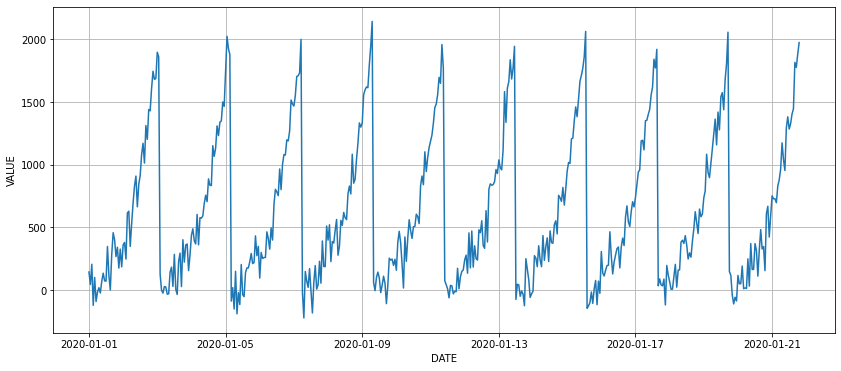

In [44]:
data = time_series_data["data"]
time = data.index
values = data

plt.figure(figsize=(14,6))
plt.plot(time, values)
plt.grid(True)
plt.xlabel("DATE")
plt.ylabel("VALUE")

In [46]:
import json

def save_data_to_json(time_series_data, 
                      filename):
    tmp = {}

    tmp["freq"] = time_series_data["freq"]
    tmp["t0"] = time_series_data["t0"]
    tmp["length"] = time_series_data["length"]
    tmp["data"] = list(time_series_data["data"])
    
    with open(filename, 'w') as file:
        json.dump(tmp, file)

save_data_to_json(time_series_data, 
                  "all.json")

!head all.json

{"freq": "H", "t0": "2020-01-01 00:00:00", "length": 500, "data": [144.80478548905717, 45.00881417586584, 206.63823224414463, -121.41431283450143, 101.3507629444087, -90.6158383742153, -15.433326706578718, 19.254970909344472, -22.567405956693563, 70.9217282036791, 135.275788445104, 74.33588301439492, 71.46850384660127, 348.1087011704674, 118.14464335458732, 1.1129862739046814, 283.41713287006576, 458.22585811543655, 403.1290464563717, 267.5678534909183, 342.1325379485155, 175.89767189067305, 327.1665257246299, 185.57667002223772, 360.6105992244239, 380.5173970455285, 247.83220839943658, 615.7190003276366, 629.8159008473672, 348.7049144312607, 530.4295968793185, 695.291049571983, 831.1241135855628, 910.1463112790755, 664.9936740794869, 844.3490833240389, 915.8470974065744, 1082.1071443253304, 1171.6607770637318, 1014.1586064376702, 1313.088042347524, 1203.0739907289649, 1441.0561685554512, 1430.8028252206936, 1609.7500593763598, 1746.6601073687991, 1682.2414913272883, 1687.9599914152607

## Performing the Train-Test Split on a Time Series Dataset

In [48]:
def load_data_from_json(filename):
    tmp = {}
    
    with open(filename) as file:
        tmp = json.load(file)
        
    index = pd.date_range(
        start=tmp["t0"], 
        freq=tmp["freq"], 
        periods=tmp["length"])
    tmp["data"] = pd.Series(
        data=tmp["data"], 
        index=index)
        
    return tmp

time_series_data = load_data_from_json(
    "all.json"
)

time_series_data

{'data': 2020-01-01 00:00:00     144.804785
 2020-01-01 01:00:00      45.008814
 2020-01-01 02:00:00     206.638232
 2020-01-01 03:00:00    -121.414313
 2020-01-01 04:00:00     101.350763
                           ...     
 2020-01-21 15:00:00    1446.858883
 2020-01-21 16:00:00    1816.850651
 2020-01-21 17:00:00    1777.403962
 2020-01-21 18:00:00    1882.318103
 2020-01-21 19:00:00    1975.278227
 Freq: H, Length: 500, dtype: float64,
 'freq': 'H',
 'length': 500,
 't0': '2020-01-01 00:00:00'}

In [49]:
def train_test_split(data, ratio=0.9):
    train_length = int(len(data) * ratio)
    pl = int(len(data)) - train_length
    prediction_length = pl
    training_dataset = data[:-prediction_length]
    target_dataset = data[train_length-1:]
    test_dataset = data
    
    return {
        "prediction_length": prediction_length,
        "training_dataset": training_dataset,
        "target_dataset": target_dataset,
        "test_dataset": test_dataset
    }

In [50]:
results = train_test_split(
    time_series_data["data"]
)
print(results["prediction_length"])

50


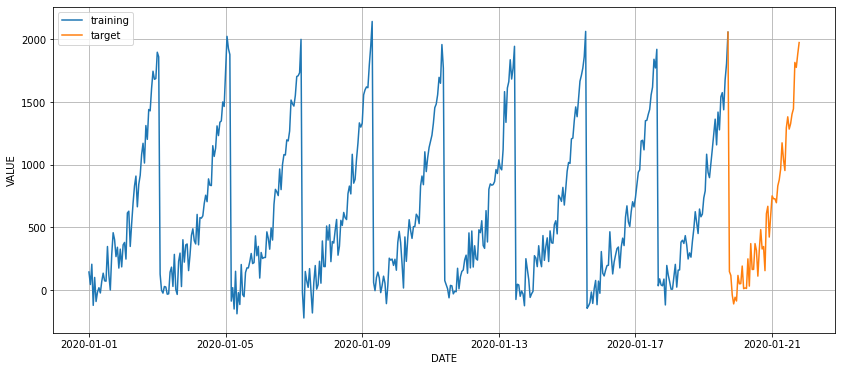

In [51]:
training_dataset = results["training_dataset"]
target_dataset = results["target_dataset"]

plt.figure(figsize=(14,6))
plt.plot(training_dataset.index, 
         training_dataset, label="training")
plt.plot(target_dataset.index, 
         target_dataset, 
         label="target")
plt.grid(True)
plt.xlabel("DATE")
plt.ylabel("VALUE")    
plt.legend()
plt.show()

In [52]:
def series_to_object(data):
    return {"start": str(data.index[0]), 
            "target": list(data)}

def series_to_jsonline(data):
    return json.dumps(series_to_object(data))

def save_data_to_jsonlines(data, filename):
    tmp = {}
    
    with open(filename, 'wb') as file:
        t = series_to_jsonline(data)
        t = t.encode("utf-8")
        file.write(t)
        file.write("\n".encode("utf-8"))

save_data_to_jsonlines(
    results["training_dataset"], 
    "training.jsonl"
)

save_data_to_jsonlines(
    results["test_dataset"], 
    "test.jsonl"
)

In [54]:
!aws s3 cp training.jsonl s3://{bucket}/{prefix}/input/training.jsonl
!aws s3 cp test.jsonl s3://{bucket}/{prefix}/input/test.jsonl

prediction_length = results["prediction_length"]
freq = time_series_data["freq"]

upload: ./training.jsonl to s3://sagemaker-us-east-1-390354360073/sagemaker-exp123/input/training.jsonl
upload: ./test.jsonl to s3://sagemaker-us-east-1-390354360073/sagemaker-exp123/input/test.jsonl


In [55]:
training_dataset = results["training_dataset"]
training_dataset

2020-01-01 00:00:00     144.804785
2020-01-01 01:00:00      45.008814
2020-01-01 02:00:00     206.638232
2020-01-01 03:00:00    -121.414313
2020-01-01 04:00:00     101.350763
                          ...     
2020-01-19 13:00:00    1575.859371
2020-01-19 14:00:00    1438.943369
2020-01-19 15:00:00    1679.536071
2020-01-19 16:00:00    1807.847508
2020-01-19 17:00:00    2058.170210
Freq: H, Length: 450, dtype: float64

In [56]:
target_dataset = results["target_dataset"]
target_dataset

2020-01-19 17:00:00    2058.170210
2020-01-19 18:00:00     148.121919
2020-01-19 19:00:00     117.607275
2020-01-19 20:00:00     -38.734586
2020-01-19 21:00:00    -109.911369
2020-01-19 22:00:00     -56.567916
2020-01-19 23:00:00     -86.640575
2020-01-20 00:00:00     117.339875
2020-01-20 01:00:00      50.450805
2020-01-20 02:00:00      52.046234
2020-01-20 03:00:00     192.242843
2020-01-20 04:00:00      11.473165
2020-01-20 05:00:00      17.827423
2020-01-20 06:00:00      13.321822
2020-01-20 07:00:00     249.571881
2020-01-20 08:00:00      32.170719
2020-01-20 09:00:00     371.201294
2020-01-20 10:00:00     164.910260
2020-01-20 11:00:00     165.498181
2020-01-20 12:00:00     371.337621
2020-01-20 13:00:00     316.423566
2020-01-20 14:00:00     111.781295
2020-01-20 15:00:00     319.316987
2020-01-20 16:00:00     482.921894
2020-01-20 17:00:00     328.279896
2020-01-20 18:00:00     347.727885
2020-01-20 19:00:00     155.477539
2020-01-20 20:00:00     610.217680
2020-01-20 21:00:00 

## Training and Deploying a DeepAR Model

In [57]:
training_s3_input_location = f"s3://{bucket}/{prefix}/input/training.jsonl"
test_s3_input_location = f"s3://{bucket}/{prefix}/input/test.jsonl"
training_s3_output_location = f"s3://{bucket}/{prefix}/output/"

train = TrainingInput(
    training_s3_input_location, 
    content_type="json"
)

test = TrainingInput(
    test_s3_input_location, 
    content_type="json"
)

context_length = prediction_length

In [59]:
container = sagemaker.image_uris.retrieve("forecasting-deepar", region, "1")

estimator = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.c4.2xlarge',
    output_path=training_s3_output_location,
    sagemaker_session=sess
)

In [60]:
estimator.set_hyperparameters(
    time_freq=freq,
    context_length=str(context_length),
    prediction_length=str(prediction_length),
    num_cells=40,
    num_layers=3,
    likelihood="gaussian",
    epochs=20,
    mini_batch_size=32,
    learning_rate=0.001,
    dropout_rate=0.05,
    early_stopping_patience=10
)

In [61]:
data_channels = {"train": train, "test": test}

In [62]:
%%time

estimator.fit(inputs=data_channels)

2022-06-10 21:40:34 Starting - Starting the training job...ProfilerReport-1654897233: InProgress
...
2022-06-10 21:41:16 Starting - Preparing the instances for training......
2022-06-10 21:42:27 Downloading - Downloading input data...
2022-06-10 21:43:02 Training - Downloading the training image.....Arguments: train
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/10/2022 21:43:50 INFO 140156080805696] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood'

In [63]:
estimator.model_data

's3://sagemaker-us-east-1-390354360073/sagemaker-exp123/output/forecasting-deepar-2022-06-10-21-40-33-509/output/model.tar.gz'

In [67]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge"
)

--------------!

In [68]:
endpoint_name = predictor.endpoint_name
endpoint_name

'forecasting-deepar-2022-06-10-21-45-21-269'

## Performing Probabilistic Forecasting with a Deployed DeepAR Model

In [69]:
Predictor = sagemaker.predictor.Predictor
predictor = Predictor(
    endpoint_name=endpoint_name, 
    sagemaker_session=sess
)

predictor.serializer = sagemaker.serializers.JSONSerializer()

quantiles=["0.1", "0.5", "0.9"]

configuration = {
    "num_samples": 100,
    "output_types": ["quantiles"],
    "quantiles": quantiles,
}

def series_to_object(data):
    return {
        "start": str(data.index[0]), 
        "target": list(data)
    }

instances = [series_to_object(training_dataset)]

http_request_data = {
    "instances": instances, 
    "configuration": configuration
}

response = predictor.predict(http_request_data)
response

b'{"predictions":[{"quantiles":{"0.1":[-69.0831298828,-123.875793457,-203.7279205322,-171.6816864014,-77.789276123,-8.4257354736,-69.1874237061,-54.0051422119,-61.7442207336,-32.5810241699,-26.3356170654,26.680809021,70.9088973999,126.3773727417,111.2920227051,178.114074707,223.0880126953,246.9423828125,241.1717987061,321.7041625977,208.0489807129,210.5973815918,222.8189697266,190.71144104,310.2881774902,351.2255859375,389.5210571289,410.5618286133,446.3055419922,482.9330444336,561.4221191406,582.6745605469,612.0657348633,637.6546630859,664.8170776367,789.6198730469,870.8226318359,976.2741088867,1055.0845947266,1108.326171875,1130.7973632812,1219.6627197266,1250.4854736328,1316.017578125,1455.7614746094,1515.923828125,1583.8618164062,1723.8688964844,1586.4143066406,814.4224243164],"0.5":[387.1301879883,105.7305679321,-36.6583480835,-39.093044281,18.6167945862,71.1249465942,41.2827415466,44.5873031616,55.5188941956,86.818687439,82.8901748657,140.1281738281,208.9259338379,246.8998260498,

In [70]:
response_data = json.loads(response)

single_result = response_data['predictions'][0]

prediction_time = training_dataset.index[-1] + pd.Timedelta(1, unit=freq)
prediction_time

Timestamp('2020-01-19 18:00:00', freq='H')

In [71]:
prediction_index = pd.date_range(
    start=prediction_time, 
    freq=freq, 
    periods=prediction_length
)

prediction_index

DatetimeIndex(['2020-01-19 18:00:00', '2020-01-19 19:00:00',
               '2020-01-19 20:00:00', '2020-01-19 21:00:00',
               '2020-01-19 22:00:00', '2020-01-19 23:00:00',
               '2020-01-20 00:00:00', '2020-01-20 01:00:00',
               '2020-01-20 02:00:00', '2020-01-20 03:00:00',
               '2020-01-20 04:00:00', '2020-01-20 05:00:00',
               '2020-01-20 06:00:00', '2020-01-20 07:00:00',
               '2020-01-20 08:00:00', '2020-01-20 09:00:00',
               '2020-01-20 10:00:00', '2020-01-20 11:00:00',
               '2020-01-20 12:00:00', '2020-01-20 13:00:00',
               '2020-01-20 14:00:00', '2020-01-20 15:00:00',
               '2020-01-20 16:00:00', '2020-01-20 17:00:00',
               '2020-01-20 18:00:00', '2020-01-20 19:00:00',
               '2020-01-20 20:00:00', '2020-01-20 21:00:00',
               '2020-01-20 22:00:00', '2020-01-20 23:00:00',
               '2020-01-21 00:00:00', '2020-01-21 01:00:00',
               '2020-01-

In [72]:
output = pd.DataFrame(
    data=single_result['quantiles'], 
    index=prediction_index
)

output

,0.1,0.5,0.9
2020-01-19 18:00:00,-69.083130,387.130188,807.143433
2020-01-19 19:00:00,-123.875793,105.730568,310.952179
2020-01-19 20:00:00,-203.727921,-36.658348,154.897705
2020-01-19 21:00:00,-171.681686,-39.093044,88.507828
2020-01-19 22:00:00,-77.789276,18.616795,138.526443
2020-01-19 23:00:00,-8.425735,71.124947,169.233978
2020-01-20 00:00:00,-69.187424,41.282742,137.628998
2020-01-20 01:00:00,-54.005142,44.587303,143.295074
2020-01-20 02:00:00,-61.744221,55.518894,165.831909
2020-01-20 03:00:00,-32.581024,86.818687,198.058167


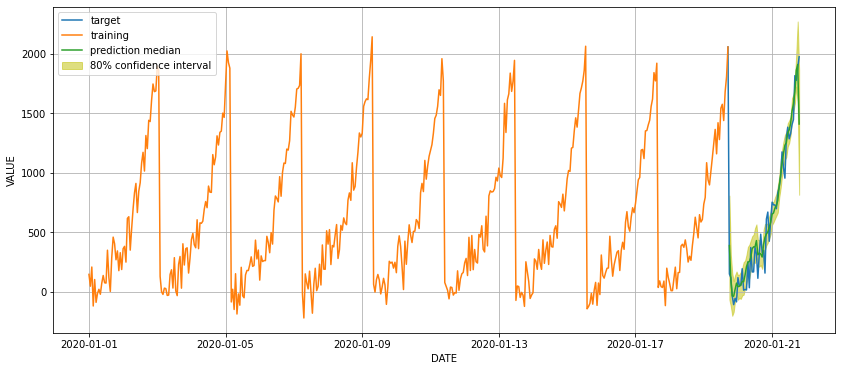

In [73]:
plt.figure(figsize=(14,6))
plt.plot(target_dataset.index, 
         target_dataset, 
         label="target")
plt.plot(training_dataset.index, 
         training_dataset, 
         label="training")
plt.grid(True)
plt.xlabel("DATE")
plt.ylabel("VALUE")    

p10 = output["0.1"]
p90 = output["0.9"]
plt.fill_between(
    p10.index, 
    p10, 
    p90, 
    color="y", 
    alpha=0.5, 
    label="80% confidence interval"
)

plt.plot(output["0.5"].index, 
         output["0.5"], 
         label="prediction median")

plt.legend()
plt.show()

In [74]:
predictor.delete_endpoint()

![](https://github.com/sparsh-ai/notebooks/raw/main/img/rec1-timeseries.gif)

That's all.

Thanks for your attention.